# 0) Introduction

In this project, we aim to train and deploy an explainable ML model that can help users estimate the interest rate they’ll be getting on their loans, much like the service offered by many banks on their websites. To do this, we needed access to quality real-world data. Unfortunately, banks tend to be rather conservative when it comes to sharing customer data. However, a few years ago, the American online bank Lending Club published a dataset containing over 151 columns and millions of rows. User identities were of course protected, but the dataset still included a ton of useful information, making it the go-to resource for training complex neural networks for risk evaluation and management models. That said, in this project, we won’t be diving into deep learning. Instead, we’re sticking with classic statistical machine learning models. We’ll also be focusing on providing a smooth, frictionless experience for users, which means letting go of much of the 151-column overload and keeping only the features that actually help us predict the interest rate.

# 1) Initial Analysis & Cleaning

## 1.0) Loading Libraries and Frameworks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Modules loaded Successfully.")

Modules loaded Successfully.


## 1.1) Loading and Selecting Data

For this notebook, we’ll be loading a sample of 100k rows from the dataset to optimize execution times, rather than working with the full dataset right away. However, for the final training phase, we plan to use the entire dataset to get the most out of our models.

In [2]:
data = pd.read_csv("Data/LoansData.csv", nrows=100000, low_memory=False)
print(f"Initial Columns : {len(list(data.columns))}\n", list(data.columns))
data.head()

Initial Columns : 151
 ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_jo

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


The columns in our dataset can be divided into two types: pre-loan data and post-loan data. For this project, we’ll be using only the pre-loan data, since including post-loan information could lead to data leakage and bias our model. Many of the pre-loan columns also contain a large number of NaN values, so that’s something we’ll need to handle as well. 

After going through and manually filtering all the loan-related columns to identify the pre-loan ones (which was pretty time-consuming), we also found that many of the pre-loan features —mostly categorical— had very low variance. This means they would provide little to no value to our models. So, to make life easier in the next steps, we decided to drop them right from the start. Here’s the final list:

In [3]:
pre_loan_features = [
    'loan_amnt', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
    'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code',
    'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
    'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
    'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
    'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
    'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_bal_joint',
    'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog'
]
pre_loan_features = [col for col in pre_loan_features if col not in ["tot_coll_amt","delinq_amnt"]]

df = data[pre_loan_features + ['int_rate']]
df.head()

,loan_amnt,term,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,desc,...,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,int_rate
0,3600.0,36 months,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.99
1,24700.0,36 months,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.99
2,20000.0,60 months,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.78
3,35000.0,60 months,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.85
4,10400.0,60 months,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.45


## 1.2) Cleaning and Handeling Missing Data

<Axes: >

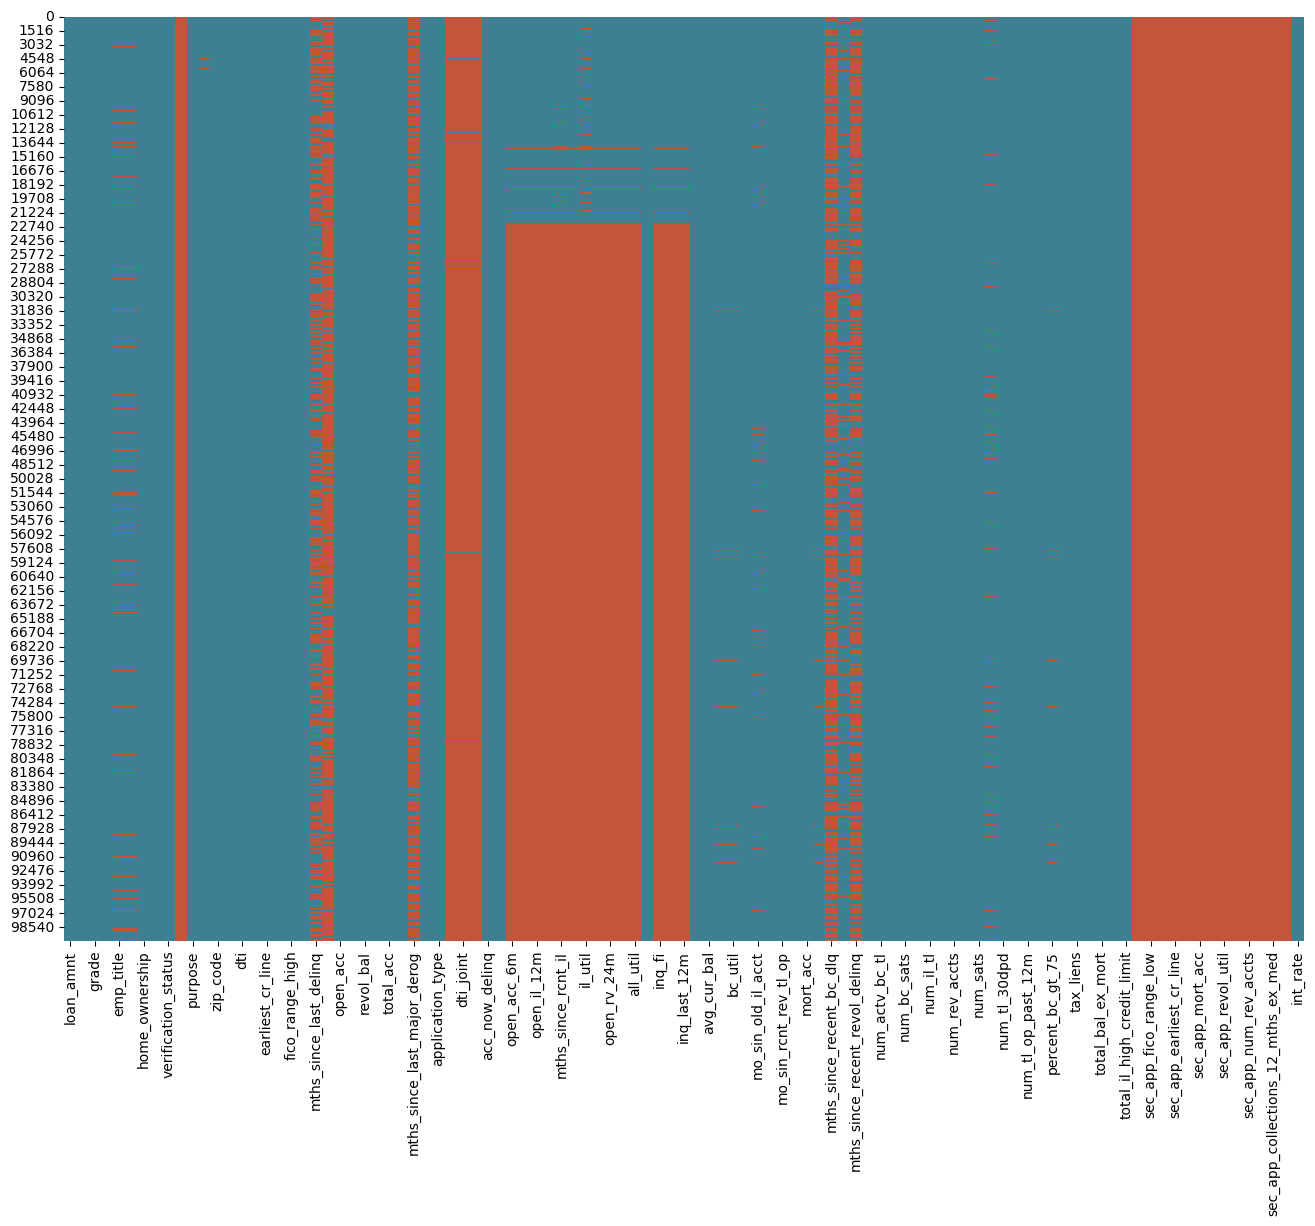

In [4]:
nan_data = df.isna().astype(int)
plt.figure(figsize=(16, 12))
custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(nan_data, cmap=custom_cmap, cbar=False)

Some features have way too many NaN values to be of any value to us, we chose to drop these features before dropping any rows with NaN values. Dropping features with more than 50% NaN values was the most reasonable to us, then dropping any rows with NaN values from the result dataframe would result in a dataset free of any NaN values and unnecessary columns.

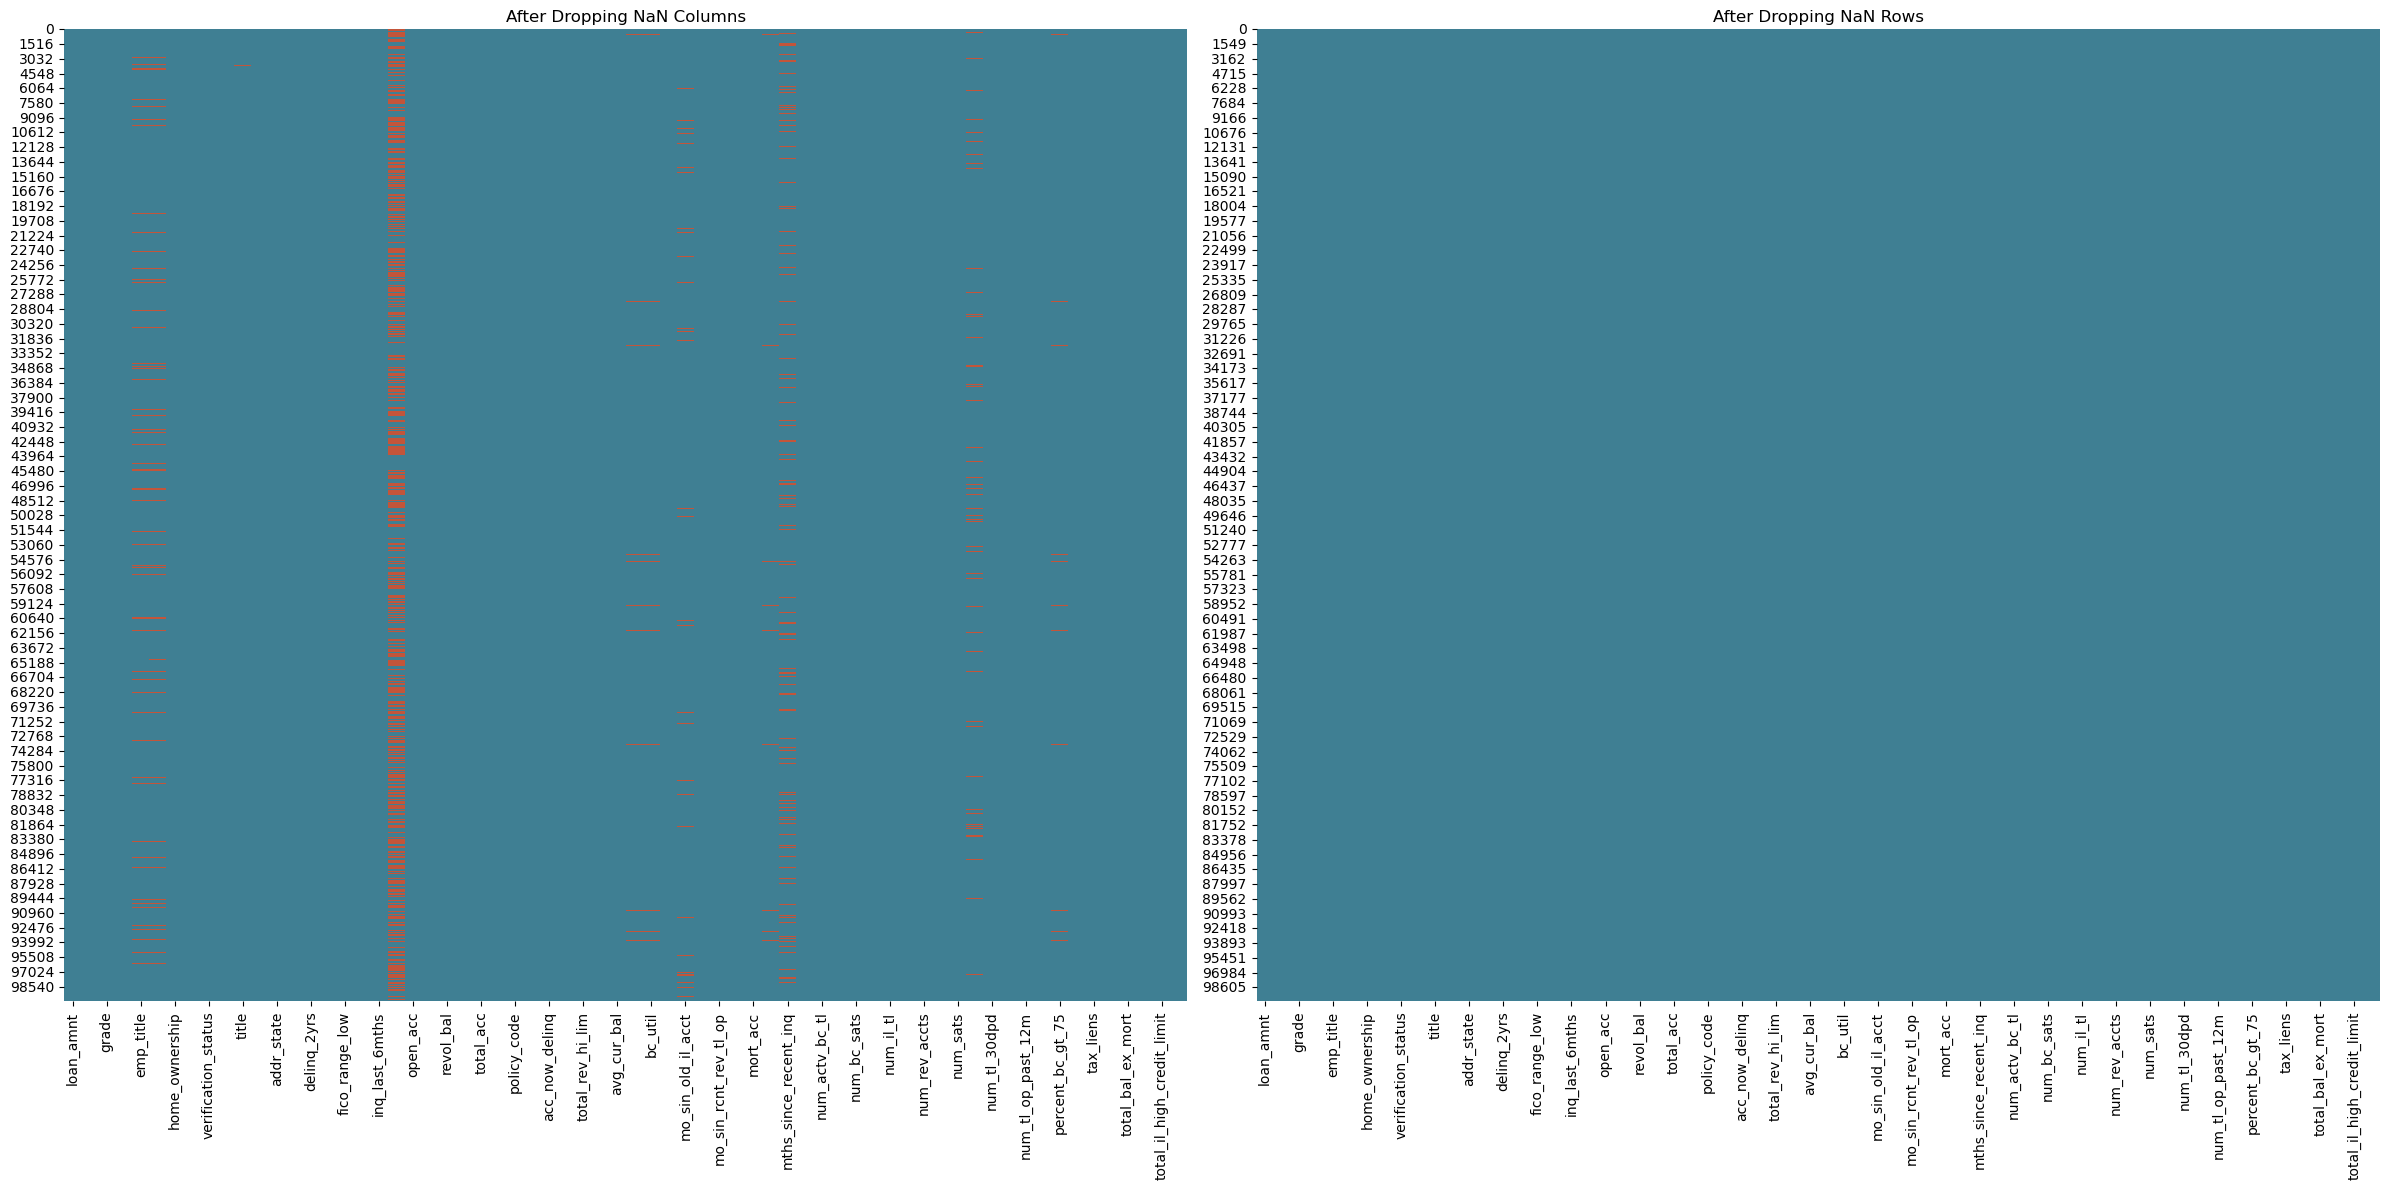

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

df = df.dropna(axis=1, thresh=len(df) - 50000)
sns.heatmap(df.isna().astype(int), cmap=sns.diverging_palette(220, 20, as_cmap=True), cbar=False, ax=axes[0])
axes[0].set_title('After Dropping NaN Columns')

df_clean = df.dropna()
sns.heatmap(df_clean.isna().astype(int), cmap=sns.diverging_palette(220, 0, as_cmap=True), cbar=False, ax=axes[1])
axes[1].set_title('After Dropping NaN Rows')

plt.tight_layout()

# 2) Statistical Analysis

## 2.1) Variance & Outlier Analysis of Quantative Features

In the dataset we’re working with, some of the categorical features are encoded numerically, while others are left as text. That’s why we first need to separate these from the actual continuous numerical variables. The code below selects the true numerical columns and then plots them, this way we avoid using boxplots on categorical features that just happen to be encoded as numbers and might look like quantitative features when they’re not.

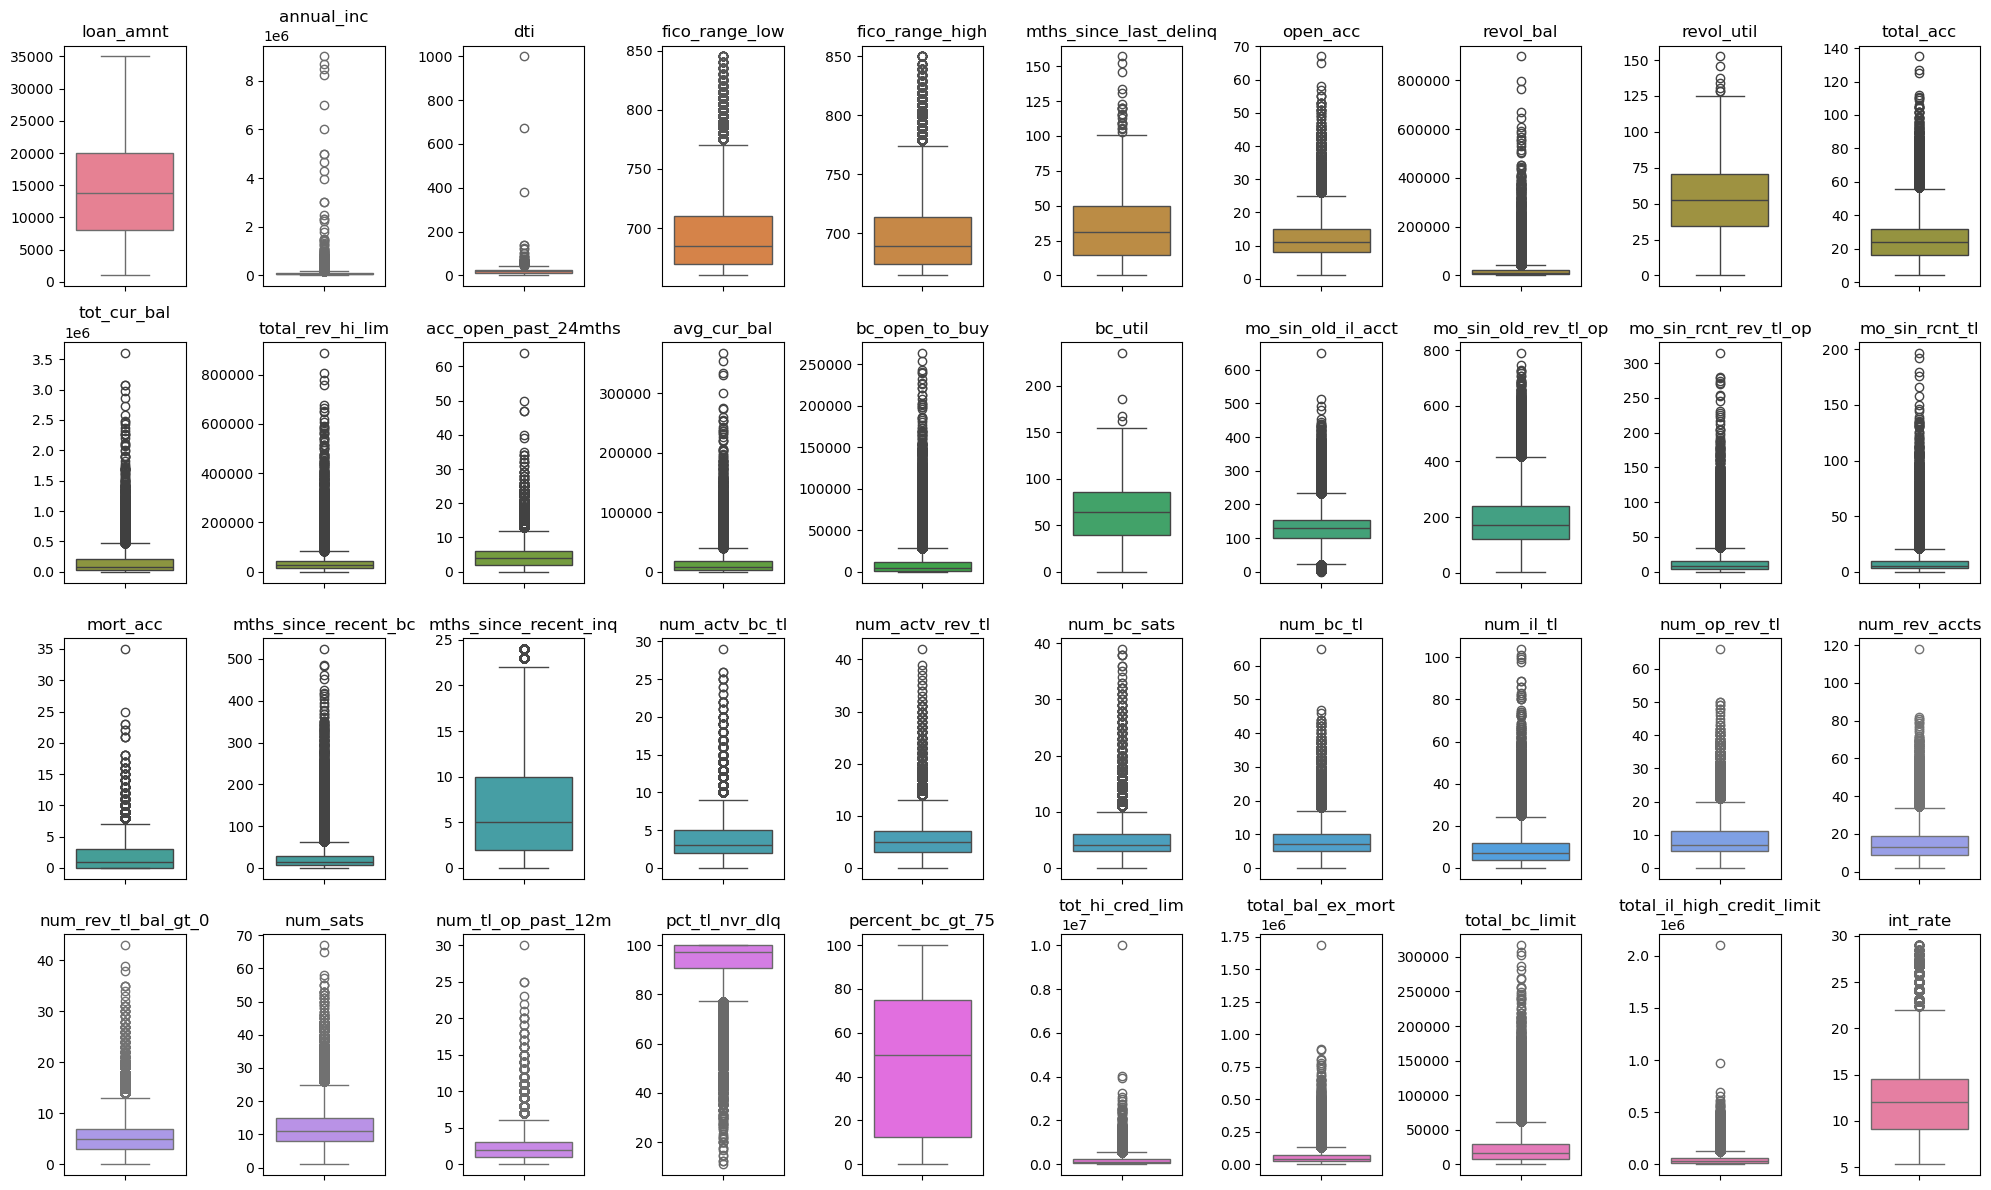

In [6]:
categorical_num_cols = ['policy_code', 'inq_last_6mths', 'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 
                        'num_tl_120dpd_2m', 'num_tl_30dpd', 'pub_rec_bankruptcies', 'delinq_2yrs', 'pub_rec', 'num_tl_90g_dpd_24m', 
                        'tax_liens', 'num_accts_ever_120_pd']
all_numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in all_numerical_cols if col not in categorical_num_cols]
num_columns = 10
num_rows = (len(numerical_cols) + num_columns - 1) // num_columns

plt.figure(figsize=(20, num_rows * 3))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.boxplot(y=df[col], color=sns.color_palette("husl", len(numerical_cols))[i-1])
    plt.title(f'{col}', fontsize=12)
    plt.ylabel('')

plt.tight_layout()

From the boxplots, we can see that many variables have a lot of outlier values that should be reduced. To handle these, we chose to use the IQR method (Interquartile Range), since it’s simple and gave us solid results as you can see in the “after” version of the boxplots below. 

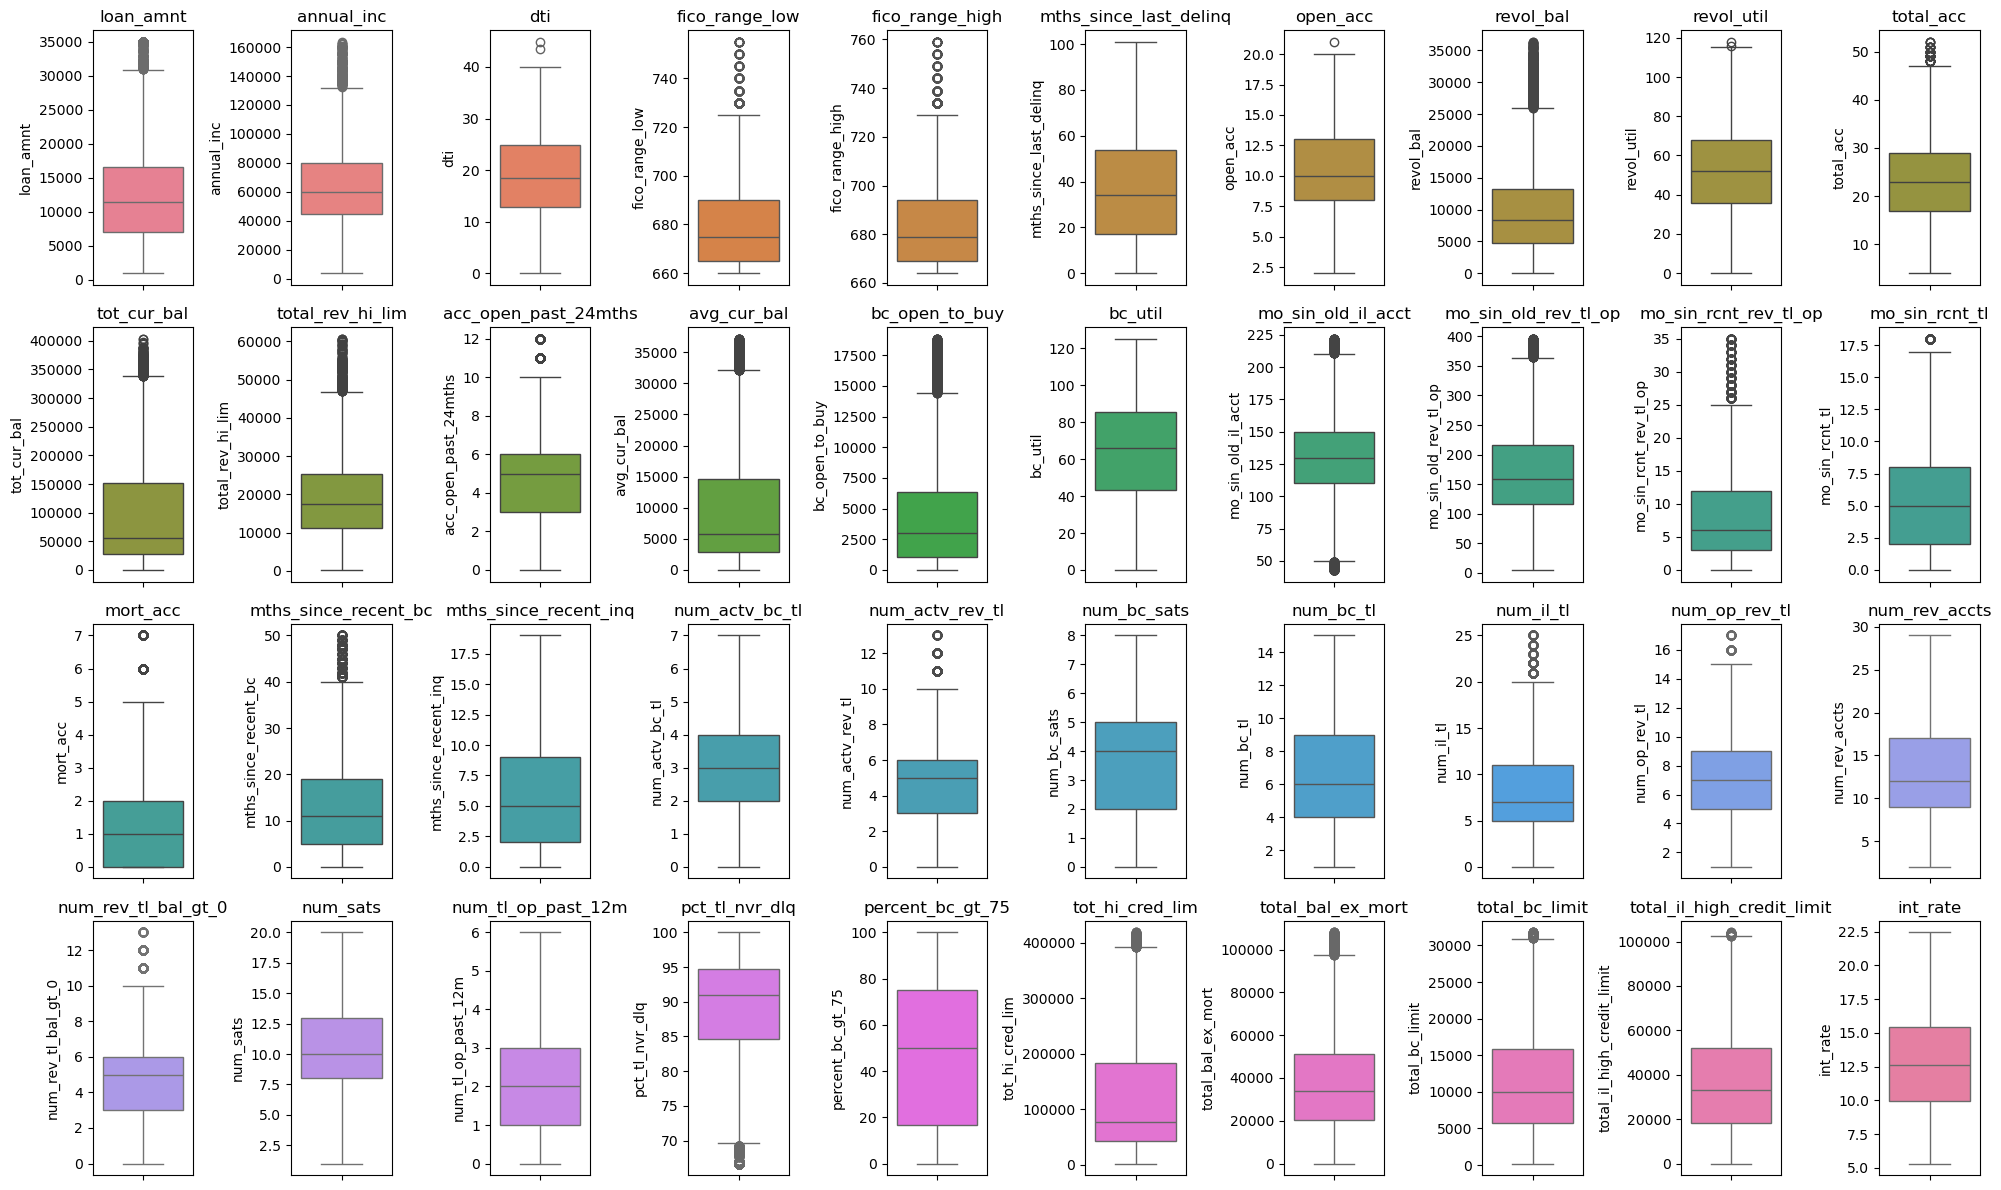

In [7]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers_iqr(df, numerical_cols)
num_cols = len(numerical_cols)
num_columns = 10
num_rows = (num_cols + num_columns - 1) // num_columns

plt.figure(figsize=(20, num_rows * 3))
palette = sns.color_palette("husl", num_cols)
for i, (col, color) in enumerate(zip(numerical_cols, palette), 1):
    plt.subplot(num_rows, num_columns, i)
    sns.boxplot(y=df[col], color=color)
    plt.title(f'{col}', fontsize=12)
    plt.xlabel('')
    plt.ylabel(col, fontsize=10)

plt.tight_layout()

## 2.2) Correlation Analysis of Quantitative Features

So far we have 41 numerical columns left, which is obviously too much to train our models on. Fortunatly, not all of these features hold important information for our models, and even if some do, they are probably highly correletated with other features which make dropping them not effect our models perfomance, to determine which of these to drop, which to keep, and which to merge we plotted the following correlation matrix :

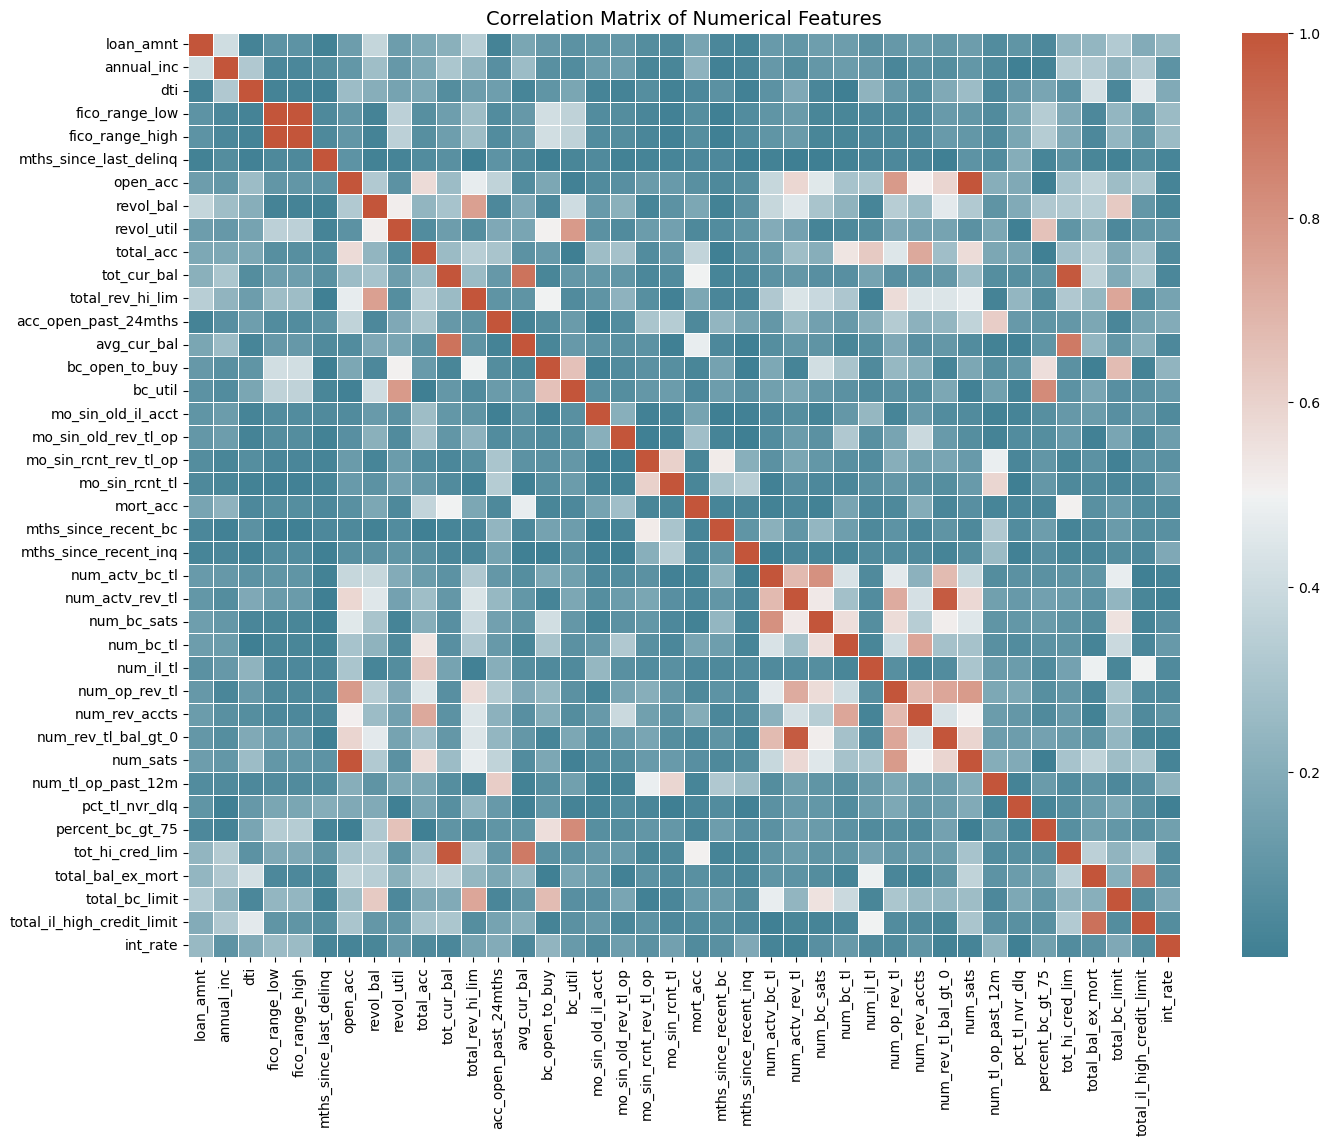

In [8]:
corr_matrix = df[numerical_cols].corr().abs()

custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap=custom_cmap, linewidths=0.5, linecolor='white')
plt.title('Correlation Matrix of Numerical Features', fontsize=14)
plt.savefig('corr_matrix.png', dpi=300)
plt.show()

After analyzing the correlation matrix, we can deduce the following:  
* Three features show significant correlation (|r| ≥ 0.15) with the interest rate: `fico_range_low`, `loan_amnt`, and `dti`  
* `fico_range_low` and `fico_range_high` are perfectly correlated (r = 1.0)  
* Most features in the dataset show low correlation with the target variable  

Based on this, we decided the following:  
* Create a new FICO score feature to replace `fico_range_low` and `fico_range_high`  
* Keep all features with high correlation with the target  
* Keep features with low correlation but important information for risk assessment  

In [9]:
df['fico'] = (df['fico_range_low'] + df['fico_range_high']) / 2
final_num_cols = ['fico', 'loan_amnt', 'dti', 'revol_util', 'total_bc_limit', 'revol_bal', 'total_acc', 'annual_inc',
                  'mths_since_recent_inq', 'open_acc', 'percent_bc_gt_75', 'int_rate'
                  # 'bc_util', 'num_actv_bc_tl', 'tot_cur_bal', 'mths_since_last_delinq', 'mort_acc'
                 ]

Here is an explanation of the final list of numerical features:  
* `fico` – New feature (average of low and high FICO)  
* `loan_amnt` – Strong correlation with target  
* `dti` – Good correlation with target  
* `revol_util` – Important for credit risk assessment  
* `total_bc_limit` – Total bankcard credit limit  
* `revol_bal` – Revolving balance  
* `total_acc` – Total number of accounts  
* `annual_inc` – Income is fundamentally important  
* `mths_since_recent_inq` – Recent credit activity  
* `open_acc` – Number of open accounts  
* `percent_bc_gt_75` – Percent of bankcards over 75% utilized  

## 2.3) Analysis & Filtering of Categorical Features

Before encoding the categorical features, we need to identify which ones are relevant and which ones aren’t, while also deciding on the appropriate encoding method for each. We’ll tackle one problematic case at a time to find the best solution in this list :

In [10]:
categorical_num_cols = ['policy_code', 'inq_last_6mths', 'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'pub_rec_bankruptcies', 'delinq_2yrs', 'pub_rec', 'num_tl_90g_dpd_24m', 'tax_liens', 'num_accts_ever_120_pd']
categorical_text_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = categorical_text_cols + categorical_num_cols
print(categorical_cols)

['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'application_type', 'policy_code', 'inq_last_6mths', 'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'pub_rec_bankruptcies', 'delinq_2yrs', 'pub_rec', 'num_tl_90g_dpd_24m', 'tax_liens', 'num_accts_ever_120_pd']


Starting with redundant features: Most of the information in "sub_grade" is already captured by "grade", the same goes for "zip_code" and "addr_state", as well as "title" and "purpose". So, for each of these three pairs, we’ll drop one to avoid redundancy.

In [11]:
df = df.drop(["sub_grade", "zip_code", "purpose"], axis=1)

For "emp_title", we noticed that there are over 8,000 unique entries, which makes it highly impractical to use as-is. So, we decided to group them into 5 broader tiers: Executive/Leadership, Senior Management, Mid-level Professional, Technical/Skilled, and Entry-level/Support.

In [12]:
def assign_job_tier(job_title):
    if pd.isna(job_title):
        return 'NaN'
    title = job_title.lower()
    if any(term in title for term in ['chief', 'president', 'vice president', 'vp', 'ceo', 'cio', 'cfo', 'cto', 'owner', 'partner', 'executive', 'director']) and not any(term in title for term in ['assistant', 'associate', 'deputy']):
        return 'Tier 1: Executive/Leadership'
    if (any(term in title for term in ['senior', 'sr.', 'sr', 'principal', 'lead', 'head', 'general manager', 'manager', 'superintendent', 'supervisor']) and not any(term in title for term in ['assistant', 'associate', 'clerk', 'technician', 'aide'])):
        return 'Tier 2: Senior Management'
    if (any(term in title for term in ['engineer', 'analyst', 'accountant', 'registered nurse', 'physician', 'attorney', 'lawyer', 'architect', 'scientist', 'developer', 'programmer', 'coordinator', 'specialist', 'administrator', 'officer', 'consultant', 'advisor']) and not any(term in title for term in ['assistant', 'aide', 'helper', 'junior'])):
        return 'Tier 3: Mid-level Professional'
    if (any(term in title for term in ['technician', 'technologist', 'mechanic', 'tech', 'operator', 'foreman', 'nurse', 'dental', 'medical', 'sales', 'representative', 'associate', 'service', 'agent', 'craftsman', 'welder', 'electrician', 'plumber']) and not any(term in title for term in ['assistant', 'aide', 'helper', 'junior'])):
        return 'Tier 4: Technical/Skilled'
    if any(term in title for term in ['clerk', 'aide', 'assistant', 'receptionist', 'driver', 'helper', 'worker', 'server', 'cashier', 'associate', 'custodian', 'janitor', 'cleaner']):
        return 'Tier 5: Entry-level/Support'
    return 'NaN'
df['job_tier'] = df['emp_title'].apply(assign_job_tier)
df = df[df['job_tier'] != 'NaN']
df = df.drop('emp_title', axis=1)

For "earliest_cr_line", the values are in a “month-year” format (like “January-2023” or “Feb-2020”). To handle this, we converted them to datetime objects using pandas and then added to numerical features list with the following code:

In [13]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
numerical_cols += ['earliest_cr_line']

The remaining categorical features have a relatively normal number of classes, so it’s easier to visualize them to detect any potential anomalies :

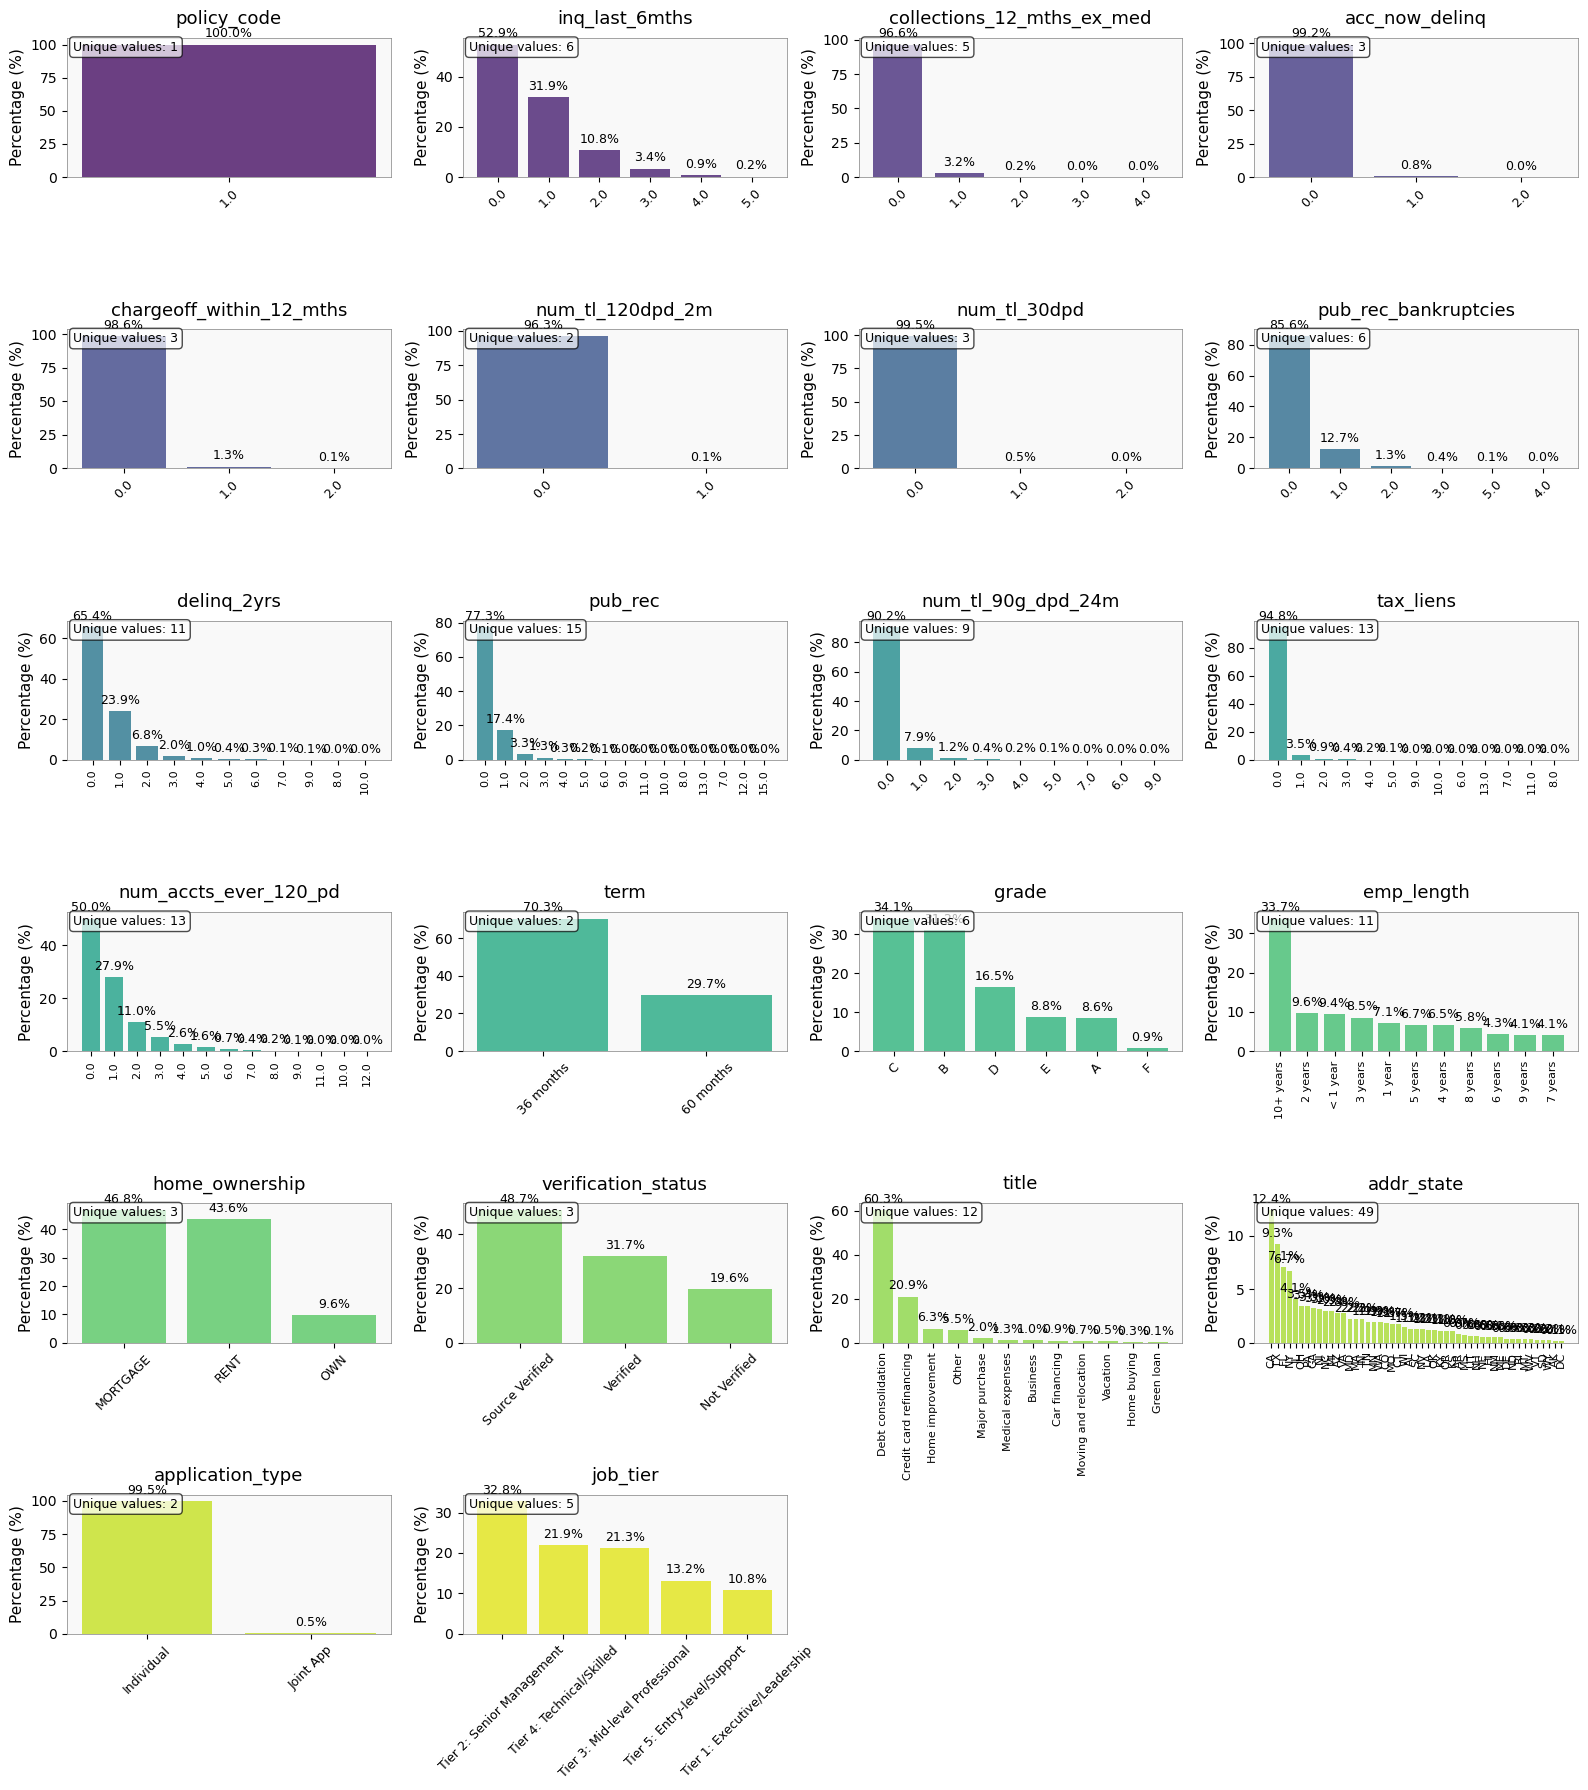

In [14]:
categorical_cols = categorical_num_cols + df.select_dtypes(include=['object', 'category']).columns.tolist()

num_columns = 4
num_rows = (len(categorical_cols) + num_columns - 1) // num_columns 

plt.figure(figsize=(16, num_rows * 3))
palette = sns.color_palette("viridis", len(categorical_cols))
for i, (col, color) in enumerate(zip(categorical_cols, palette), 1):

    value_counts = df[col].value_counts().sort_values(ascending=False)
    percentages = value_counts / len(df) * 100

    ax = plt.subplot(num_rows, num_columns, i)
    bars = ax.bar(value_counts.index.astype(str), percentages, color=color, alpha=0.8)
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                    textcoords="offset points", ha='center', va='bottom', fontsize=9)
    plt.title(col, fontsize=13, pad=10)
    plt.xlabel('', fontsize=11)
    plt.ylabel('Percentage (%)', fontsize=11)
    
    if len(value_counts) > 10 or (col in ['title', 'addr_state'] and len(value_counts) > 5):
        plt.xticks(rotation=90, fontsize=8)
    else:
        plt.xticks(rotation=45, fontsize=9)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    ax.set_facecolor('#f9f9f9')
    plt.annotate(f'Unique values: {df[col].nunique()}', xy=(0.02, 0.98), xycoords='axes fraction',
                 ha='left', va='top', fontsize=9, bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))

plt.tight_layout()
plt.show()

As we can see, many features are extremely biased, with more than 90% of their values falling into a single class. This kind of imbalance can actually hurt model performance, so dropping these features is the best course of action.
The distributions after dropping them look much better:

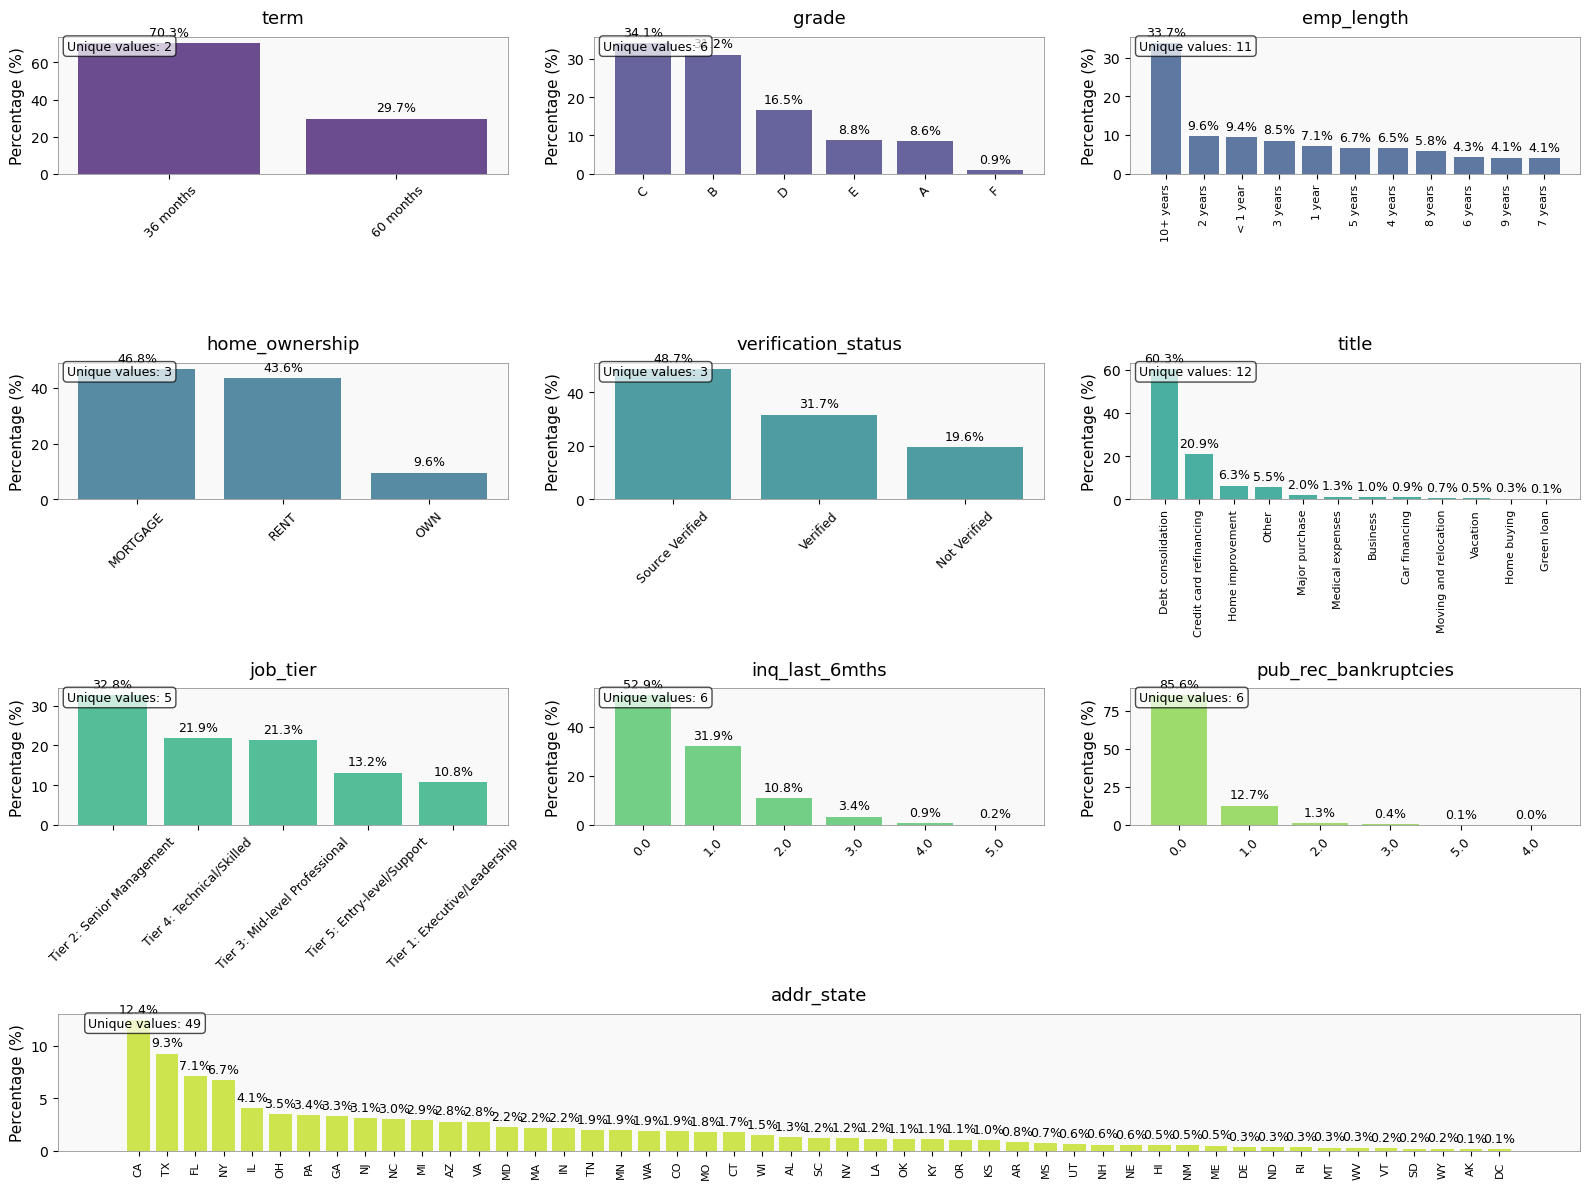

In [15]:
categorical_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'title', 'job_tier', 'inq_last_6mths', 'pub_rec_bankruptcies', 'addr_state']
df = df[categorical_cols + final_num_cols]
num_rows, num_columns = 4, 3

plt.figure(figsize=(16, num_rows * 3))
palette = sns.color_palette("viridis", len(categorical_cols))
for i, (col, color) in enumerate(zip(categorical_cols[:-1], palette[:-1]), 1):
    
    value_counts = df[col].value_counts().sort_values(ascending=False)
    percentages = value_counts / len(df) * 100
    
    ax = plt.subplot(num_rows, num_columns, i)
    bars = ax.bar(value_counts.index.astype(str), percentages, color=color, alpha=0.8)
    for bar in bars:
        ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()), 
                   xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    
    plt.title(col, fontsize=13, pad=10)
    plt.ylabel('Percentage (%)', fontsize=11)
    plt.xticks(rotation=90 if len(value_counts) > 10 or (col == 'title' and len(value_counts) > 5) else 45,
              fontsize=8 if len(value_counts) > 10 else 9)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    ax.set_facecolor('#f9f9f9')
    plt.annotate(f'Unique values: {df[col].nunique()}', xy=(0.02, 0.98), xycoords='axes fraction',
                ha='left', va='top', fontsize=9, bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))

ax = plt.subplot(num_rows, 1, num_rows)
value_counts = df['addr_state'].value_counts().sort_values(ascending=False)
percentages = value_counts / len(df) * 100
bars = ax.bar(value_counts.index.astype(str), percentages, color=palette[-1], alpha=0.8)
for bar in bars:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
               xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.title('addr_state', fontsize=13, pad=10)
plt.ylabel('Percentage (%)', fontsize=11)
plt.xticks(rotation=90, fontsize=8)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('gray')
    spine.set_linewidth(0.5)
ax.set_facecolor('#f9f9f9')
plt.annotate(f'Unique values: {df["addr_state"].nunique()}', xy=(0.02, 0.98), xycoords='axes fraction',
           ha='left', va='top', fontsize=9, bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))

plt.tight_layout()
plt.show()

## 1.5) Encoding Categorical Features:

The results of our analysis of Categorical Features is far from done, we still have to properly encode these features for them to be usable :
* `term` : Binary encoding (0=36 months, 1=60 months)
* `grade` : Grades have a natural ordering so we'll just map them to corresponding values(A=0, B=1, C=2, etc.)
* `emp_length` : We'll be grouping these them to three categories : less than 1, one to 5, 5 to 10, more than 10
* `home_ownership` : One-hot encoding by creating dummy variables 
* `verification_status` : Also One-hot encoding with dummy variables
* `title` : Many categories with high class imbalance so we'll be grouping them then one-hot encoding
* `job_tier` : Ordinal encoding since tiers have natural numeric ordering
* `inq_last_6mths` : Keep as numeric since it's already numeric with relatively few unique values
* `pub_rec_bankruptcies` : Since it's highly skewed (85.4% are 0) we'll convert it to binary (has bankruptcy: yes/no)
* `addr_state` : Has too many categories while providing very little info to our models so it'll be dropped

In [16]:
# Term
df['term_encoded'] = df['term'].apply(lambda x: 0 if '36' in str(x) else 1)
# Grade
grade_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
df['grade_encoded'] = df['grade'].map(grade_mapping)
# Employment length
df['emp_length_category'] = df['emp_length'].apply(lambda x: 
    0 if pd.isna(x) or 'less than 1' in str(x).lower() or '< 1' in str(x) else
    1 if any(str(i) in str(x) for i in range(1, 6)) else
    2 if any(str(i) in str(x) for i in range(6, 10)) else
    3)
# Home ownership
home_dummies = pd.get_dummies(df['home_ownership'], prefix='home')
df = pd.concat([df, home_dummies], axis=1)
# Verification Status
verification_dummies = pd.get_dummies(df['verification_status'], prefix='verified')
df = pd.concat([df, verification_dummies], axis=1)
# Loan Purpose
df['title'] = df['title'].fillna('Other')
df['title_grouped'] = 'Other'
df.loc[df['title'] == 'Debt consolidation', 'title_grouped'] = 'Debt_consolidation'
df.loc[df['title'] == 'Credit card refinancing', 'title_grouped'] = 'Credit_card_refinancing'
df.loc[df['title'].isin(['Home improvement', 'Home buying', 'Moving and relocation']), 'title_grouped'] = 'Home_related'
df.loc[df['title'].isin(['Major purchase', 'Car financing', 'Vacation', 'Medical expenses']), 'title_grouped'] = 'Large_expenses'
df.loc[df['title'] == 'Business', 'title_grouped'] = 'Business'
title_dummies = pd.get_dummies(df['title_grouped'], prefix='title')
df = pd.concat([df, title_dummies], axis=1)
# Job Tier
df['job_tier_encoded'] = df['job_tier'].str.extract(r'Tier (\d+)').astype(float) - 1
# Bankruptcy
df['has_bankruptcy'] = (df['pub_rec_bankruptcies'] > 0).astype(int)

df.drop(['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'title', 'title_grouped', 'job_tier', 
         'inq_last_6mths', 'pub_rec_bankruptcies', 'addr_state'], axis=1, inplace=True, errors='ignore')

# 3) Data Preparation Conclusion

After a thorough process of cleaning, handling missing values, analyzing outliers, and evaluating feature correlations, we've significantly refined our dataset. We started with 151 columns and have now condensed it down to 28 relevant features, carefully selected and engineered for optimal model performance. Quantitative features have been treated for outliers, and categorical features have been logically encoded or grouped, resulting in a fully numeric DataFrame free of missing values. This structured dataset is now primed and ready for the next stage: model training.

In [21]:
display(df.head())
df.to_csv('Data/LoansData_Processed.csv', index=False)

,fico,loan_amnt,dti,revol_util,total_bc_limit,revol_bal,total_acc,annual_inc,mths_since_recent_inq,open_acc,...,verified_Source Verified,verified_Verified,title_Business,title_Credit_card_refinancing,title_Debt_consolidation,title_Home_related,title_Large_expenses,title_Other,job_tier_encoded,has_bankruptcy
0,677.0,3600.0,5.91,29.7,2400.0,2765.0,13.0,55000.0,4.0,7.0,...,False,False,False,False,True,False,False,False,1.0,0
7,707.0,20000.0,17.61,5.7,14500.0,826.0,15.0,85000.0,8.0,8.0,...,False,False,False,False,False,False,True,False,4.0,0
24,697.0,6000.0,13.28,72.0,3800.0,8563.0,16.0,100000.0,6.0,9.0,...,False,False,False,False,True,False,False,False,2.0,0
47,667.0,8800.0,5.18,76.6,8500.0,9195.0,24.0,92000.0,6.0,9.0,...,True,False,False,True,False,False,False,False,3.0,0
58,677.0,7200.0,19.25,47.6,19000.0,9051.0,25.0,50000.0,10.0,13.0,...,False,False,False,False,True,False,False,False,1.0,0
